In [57]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
os.getcwd()

'/Users/carolinesofieljorring/Desktop/Social-Data-Project'

In [50]:
# enhedsomraade 
cols = ['kategori','id','ny_dm_element','traeart','slaegtsnavn','planteaar','faeldningsaar','bydelsnavn','byrumstype','vejnavn','fritrumsprofil','stammeomfang','placering','omgivelse','reg_dato','opdateret_dato','wkb_geometry']
df = pd.read_csv('data/trae_basis.csv',sep=',',usecols=cols)
#drop_columns = ['FID','under_element','arbsted_tekst_id','plantet_halvaar','vaekstsaeson','underordnet_stednavn','omraade','kronediameter','vaekstmedie','beskyttelse','sundhed','skudtilsvaekst','andre_vaekstforhold','bevaringsvaerdi','driftstatus_gadetrae','garantiperioden_udloeber','vanding_i_aar','ejer','driftsorganisation','driftsorganisation_vanding','driftsaftale_edoc_nr','']
df.head()

,kategori,id,ny_dm_element,traeart,slaegtsnavn,planteaar,faeldningsaar,bydelsnavn,byrumstype,vejnavn,fritrumsprofil,stammeomfang,placering,omgivelse,reg_dato,opdateret_dato,wkb_geometry
0,gadetræ,2755,Gade- og allétræer,Platanus hybr. acerifolia,Platan,2008.0,Ikke registreret,Vanløse,Gader og pladser,Sallingvej,"4,5 m",40 - 60,Siderabat,Fast belægning,2011-07-01T00:00:00,2022-03-21T10:32:29.888,POINT (12.506472982261277 55.69325544860847)
1,gadetræ,79754,Gade- og allétræer,Tilia hybr. europaea 'Pallida',Lind,2005.0,Ikke registreret,Valby,Gader og pladser,Mølle Allé,"4,5 m",18 - 20,Fortov,Fast belægning,2016-04-07T09:47:27.171,2022-03-21T10:32:29.888,POINT (12.517024058234247 55.665248690540835)
2,gadetræ,84790,Gade- og allétræer,Tilia hybr. europaea 'Pallida',Lind,2018.0,Ikke registreret,Valby,Gader og pladser,Mølle Allé,"4,5 m",18 - 20,Fortov,Fast belægning,2018-01-08T00:00:00,2022-03-21T10:32:29.888,POINT (12.517473257630915 55.6651562247192)
3,gadetræ,79761,Formede træer,Tilia hybr. europaea 'Pallida',Lind,1960.0,Ikke registreret,Valby,Gader og pladser,Mølle Allé,"4,5 m",18 - 20,Fortov,Fast belægning,2016-04-07T09:47:27.171,2022-03-21T10:32:29.888,POINT (12.515573415316043 55.665570503006286)
4,gadetræ,6881,Gade- og allétræer,Robinia pseudoacacia 'Nyirsegi',Robinie,2008.0,Ikke registreret,Vesterbro-Kongens Enghave,Gader og pladser,Dannebrogsgade,"4,5 m",18 - 20,Fortov,Fast belægning,2011-07-01T00:00:00,2022-03-09T17:16:03.502,POINT (12.552988210062669 55.669186278185045)


In [ ]:
# Idéen med datasættet, hvad vil vi undersøge?
# hvorfor vigtigt? Vigtigt med træer ift. klimaaflastning (CO2), god stemning i byer, træer/grønne områder skaber ro 

# Exploratory analysis
# Location
# Hvor mange træer i Kbh, hvor mange træer i de forskellige bydele
# Hvilke slags træer - overordnet, i de forskellige bydele 
# Geo plot, brug lat,loc

# Hvilke træer
# Hvornår er træerne plantet - i hvilke år plantes der flest
# Hvilke typer træeer er plantet hvornår  
# Hvor store er træerne? Forskel på størrelse ift. bydele 

In [51]:
## Data preprocessing
print(df.shape[0],len(df['id'].unique()))
df.duplicated(subset='id',keep=False) # rows with same id 
df = df.drop_duplicates(subset='id',keep='last') # drop duplicated rows
print(df.duplicated(subset=['id']).any())
print(df.shape[0],len(df['id'].unique()))

62079 62063
False
62063 62063


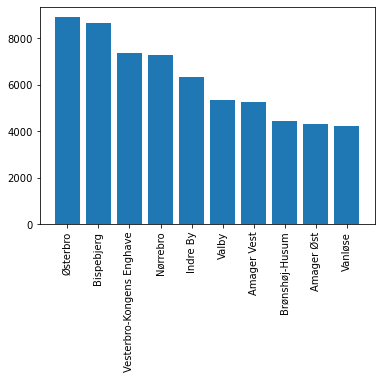

In [64]:
# Exploratory analysis
n_trees = df.shape[0] # number of trees in Copenhagen
count_bydele = df.groupby(['bydelsnavn']).size().sort_values(ascending=False)
plt.figure()
plt.bar(count_bydele.index,count_bydele.values)
plt.xticks(count_bydele.index,rotation=90)
plt.show()

In [65]:
# For bokeh visualisations
from bokeh.plotting import figure
from bokeh.models.widgets import Panel, Tabs
from bokeh.io import show, output_notebook, reset_output
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.layouts import row

In [66]:
df['kategori'].unique()

array(['gadetræ', 'parktræ', 'privat træ', 'Ikke defineret'], dtype=object)

In [67]:
df['ny_dm_element'].unique()

array(['Gade- og allétræer', 'Formede træer', 'Park- og naturtræer',
       'Private træer', '0', 'Træer i bevoksninger'], dtype=object)

In [68]:
df['slaegtsnavn'].unique()

array(['Platan', 'Lind', 'Robinie', 'Løn', 'Elm', 'Æble', 'Røn', 'Ask',
       'Pære', 'Pil', 'Tretorn', 'El', 'Eg', 'Kirsebær/Blomme',
       'Hestekastanie', 'Tjørn', 'Birk', 'Bærmispel', 'Kornel', 'Avnbøg',
       'Guldregn', 'Gingko', 'Vandgran', 'Snebolle', 'Lærk', 'Skyrækker',
       'Hassel', 'Ambratræ', 'Poppel', 'Taks', 'Thuja', 'Fyr',
       'Hibiscus-slægten', 'Paulównia', 'Kristtorn', 'Tulipantræ',
       'Valnød', 'Sophora', 'Sølvblad ', 'Ene', 'Kinesertræ', 'Ceder',
       'Ikke registreret', 'Trompetkrone', 'Kastanie', 'Tusindtop',
       'Taxodium, ikke navngivet på dansk', 'Gran', 'Bøg', 'Vingevalnød',
       'Parrotia, ikke navngivet på dansk', 'Nyssa', 'Kvæde', 'Magnolia',
       'Zelkova, ikke navngivet på dansk', 'Hjertetræ', 'Humlebøg',
       'Syren-slægten', 'Hyld', 'Hemlock', 'Sydbøg', 'Storaks', 'Mispel',
       'Morbær', 'Bjergthe', 'Osagetorn', 'Albizia (Ærteblomst-fam,)',
       'Dværgcypres', 'Sequoiadendron, ikke navngivet på dansk', nan,
       'Duetræ',

In [69]:
df['planteaar'].unique()

array([2008., 2005., 2018., 1960., 2012., 2022., 1977., 2009., 2011.,
       2003., 2021., 1995., 2010., 1980., 1970., 2016., 2015., 2019.,
       2006., 2002., 2001., 1990., 1988., 1998., 1992., 2007., 1947.,
       2014., 2000., 1918., 1900., 2013., 1930., 1940., 1982., 2004.,
       1985., 1972., 1953., 2017., 1969., 2020., 1944., 1950., 1925.,
       1975., 1999., 1951., 1996., 1924., 1920., 1984., 1997., 1989.,
       1942., 1850., 1935., 1948.,   nan, 1936., 1991., 1971., 1976.,
       1994., 1978., 1906., 1965., 1941., 1974., 1973., 1979., 1952.,
          0., 1987., 1961., 1909., 1955., 1905., 1945., 1981., 1986.,
       1773., 1993., 1933., 1983., 1912., 1902., 1907., 1908., 1963.,
       1967., 1915., 1927., 1968., 1959., 1910., 1962., 1870., 1957.,
       1958., 1895., 1966., 1892., 1954., 1932., 1943., 1937., 1931.,
       1891., 1890., 1901., 1926., 1928., 1880., 1919., 1964., 1886.,
       1899., 1913., 1923., 1934., 1922., 1916., 1860., 1914., 1938.,
       1939., 1946.]

In [122]:
df1 = df.groupby(['bydelsnavn','ny_dm_element']).size().reset_index()
df1.columns = ['district','category','count']
print(df1.columns)
print(len(df1['category'].unique()))

df1['fraction district'] = 0
for name in count_bydele.index:
    df1.loc[df1['district']==name,'fraction district'] = df1.loc[df1['district']==name,'count']/count_bydele[name]
    #print(df1.loc[df1['district']==name,'fraction district'].sum())

count_category = df.groupby('ny_dm_element').size()
df1['fraction category'] = 0
for name in count_category.index:
    df1.loc[df1['category']==name,'fraction category'] = count_category[name]/count_category.sum()

df1.head()

Index(['district', 'category', 'count'], dtype='object')
6


,district,category,count,fraction district,fraction category
0,Amager Vest,Formede træer,82,0.015664,0.035480
1,Amager Vest,Gade- og allétræer,2824,0.539446,0.408536
2,Amager Vest,Park- og naturtræer,1782,0.340401,0.453056
3,Amager Vest,Private træer,57,0.010888,0.017966
4,Amager Vest,Træer i bevoksninger,490,0.093601,0.084559


In [125]:
output_notebook()
src1 = ColumnDataSource(df1)
p1 = figure(plot_width = 900, plot_height = 600, title = "n_trees_by_district",x_axis_label = "district", y_axis_label = "n_samples")
#Define the columns to use for each bar
bar_cols = ['category']
colors = ['red', 'blue','green','purple','yellow','pink']
#Create empty list for custom legend
items1 = []
#Add bars by using p.var
bar1 ={}
# Insert fraction values in bars
for indx, i in enumerate(bar_cols):
    bar1[i] = p1.vbar(x="district", top = i, source= src1, width=0.5, legend_label=i, color=colors[indx], muted =True)
    #Append items to create the legend
    items1.append((bar_cols[indx], [bar1[i]]))

show(p1)



Loading BokehJS ...